# State Construction Task

In [6]:
from datetime import datetime
import itertools
import io

import numpy as np
import scipy.sparse as sp
import tensorflow as tf

from tqdm import tqdm
import matplotlib.pyplot as plt

generates equidistributed points on unit nd-sphere (see [here](https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf))

In [7]:
def equidistributed_points(dim, dist):
    with np.errstate(divide='ignore'):
        if np.isnan(dist):
            dist = 4 * np.pi
        if dim == 2:
            phis = np.arange(0, 2 * np.pi, dist)
            return np.vstack([np.cos(phis), np.sin(phis)])
        else:
            slices = []
            for phi in np.arange(0, np.pi, dist):
                proj_points = equidistributed_points(dim - 1, dist / np.sin(phi))
                points = np.vstack([np.full((1, proj_points.shape[1]), np.cos(phi)), np.sin(phi) * proj_points])
                slices.append(points)
            return np.hstack(slices)

## solve using Tensorflow

parametric hamiltonian generator with `tf.Variable`

In [26]:
dim = 2

def h_generator(batch_size):
    def generate_parametric(n, dv_lambda, name):
        params = tf.get_variable(name, dtype='float64', shape=(batch_size, n), initializer=tf.truncated_normal_initializer)
        params = tf.cast(params, 'complex128')
        places = tf.constant(np.stack([dv_lambda(c) for c in range(n)]), dtype='complex128')
        return tf.tensordot(params, places, axes=[1, 0])
    

    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    h = generate_parametric(dim - 1, neardiag, 'neardiag') + generate_parametric(dim, diag, 'diag')
    
    return h

design own solver

In [52]:
def batch_solve_tensorflow(dim, h_generator, source, targets, batch_size):
    tf.reset_default_graph()
    
    with tf.device('/cpu:0'):
        source = tf.tile(tf.expand_dims(tf.constant(source, dtype='complex128'), axis=0), [batch_size, 1])
        target = tf.placeholder(dtype='complex128', shape=(batch_size, dim))

        h = h_generator(batch_size)
        
        gate = tf.linalg.expm(1j * h)
        estimated_target = tf.matmul(gate, tf.expand_dims(source, 2))

        target_dot = tf.matmul(tf.expand_dims(target, 2), estimated_target, adjoint_a=True)
        fidelities = tf.abs(target_dot)
        loss = 1 - tf.reduce_mean(fidelities)

        optimize_op = tf.train.MomentumOptimizer(momentum=0.8, learning_rate=0.5).minimize(loss)

    with tf.Session() as session:
        for t in tqdm(targets):
            init_op = tf.global_variables_initializer()
            session.run(init_op)
            for i in range(5000): # todo, improve stop
                session.run(optimize_op, feed_dict={target: t})
            yield session.run(fidelities, feed_dict={target: t})

In [53]:
angle = 0.3

source = np.array([1] + [0] * (dim - 1))
map_points = equidistributed_points(2 * dim, angle).T
targets = map_points[:, :dim] + 1j * map_points[:, dim:]
print(targets.shape)

replica = 2
ts = np.repeat(targets, replica, axis=0)
batch_size = 32
ts = np.vstack([ts, np.zeros((ts.shape[0] % batch_size, dim))])
ts = np.split(ts, ts.shape[0] // batch_size)
res = batch_solve_tensorflow(dim, h_generator, source, ts, batch_size)
res = np.vstack(res)
res = res[:targets.shape * replica,]
res = res.reshape((target.shape, replica))
res = np.max(res, axis=1)

(768, 2)
(32, 2)


/home/grizzly/Works/University/QC Research/quantum-state-construction/code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


KeyboardInterrupt: 

In [ ]:
f_min = min(fidelities)
d = np.cos(angle)
MGF = (np.sqrt(d * f_min) - np.sqrt((1 - d) * (1 - f_min))) ** 2

print('d: ', d)
print('minimum fidelity: ', f_min)
print('average fidelity: ', sum(fidelities) / len(fidelities))
print('MGF: ', MGF)

In [70]:
angle = 0.05

source = np.array([1] + [0] * (dim - 1))
targets = list(equidistributed_points(dim, angle).T)
fidelities = batch_solve_tensorflow(dim, h_generator, source, targets)






  0%|          | 0/126 [00:00<?, ?it/s]




  1%|          | 1/126 [00:02<05:12,  2.50s/it]




  2%|▏         | 2/126 [00:04<05:01,  2.43s/it]




  2%|▏         | 3/126 [00:07<04:52,  2.38s/it]




  3%|▎         | 4/126 [00:09<04:45,  2.34s/it]




  4%|▍         | 5/126 [00:11<04:47,  2.38s/it]




  5%|▍         | 6/126 [00:14<04:56,  2.47s/it]




  6%|▌         | 7/126 [00:16<04:55,  2.48s/it]




  6%|▋         | 8/126 [00:19<04:56,  2.51s/it]




  7%|▋         | 9/126 [00:22<04:54,  2.52s/it]




  8%|▊         | 10/126 [00:24<05:00,  2.59s/it]




  9%|▊         | 11/126 [00:27<04:55,  2.57s/it]




 10%|▉         | 12/126 [00:30<05:02,  2.65s/it]




 10%|█         | 13/126 [00:33<05:11,  2.76s/it]




 11%|█         | 14/126 [00:36<05:35,  2.99s/it]




 12%|█▏        | 15/126 [00:39<05:41,  3.07s/it]




 13%|█▎        | 16/126 [00:42<05:34,  3.04s/it]




 13%|█▎        | 17/126 [00:46<05:35,  3.08s/it]




 14%|█▍        | 18/126 [00:49<05:53,  3.27s/it]




 15%|█

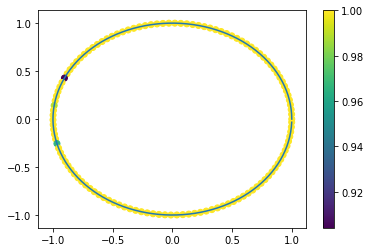

In [71]:
xs = np.array([t[0] for t in targets])
ys = np.array([t[1] for t in targets])
cs = np.array([float(f) for f in fidelities])
plt.plot(xs, ys)
# xs = xs[cs < 0.7]
# ys = ys[cs < 0.7]
# cs = cs[cs < 0.7]
plt.scatter(xs, ys, c=cs)
plt.colorbar()
# print('\n'.join([str(x) for x in list(zip(xs, ys))]))

In [72]:
replica_target = [min(zip(fidelities, targets), key=lambda x: x[0])[1]] * 20
replica_fidelities = batch_solve_tensorflow(dim, h_generator, source, critical_target)






  0%|          | 0/20 [00:00<?, ?it/s]




  5%|▌         | 1/20 [00:02<00:48,  2.55s/it]




 10%|█         | 2/20 [00:04<00:44,  2.48s/it]




 15%|█▌        | 3/20 [00:07<00:41,  2.45s/it]




 20%|██        | 4/20 [00:09<00:38,  2.41s/it]




 25%|██▌       | 5/20 [00:11<00:35,  2.39s/it]




 30%|███       | 6/20 [00:14<00:33,  2.39s/it]




 35%|███▌      | 7/20 [00:16<00:31,  2.39s/it]




 40%|████      | 8/20 [00:19<00:28,  2.38s/it]




 45%|████▌     | 9/20 [00:21<00:26,  2.37s/it]




 50%|█████     | 10/20 [00:23<00:23,  2.35s/it]




 55%|█████▌    | 11/20 [00:26<00:22,  2.48s/it]




 60%|██████    | 12/20 [00:29<00:20,  2.51s/it]




 65%|██████▌   | 13/20 [00:31<00:17,  2.51s/it]




 70%|███████   | 14/20 [00:34<00:15,  2.58s/it]




 75%|███████▌  | 15/20 [00:36<00:13,  2.61s/it]




 80%|████████  | 16/20 [00:39<00:10,  2.51s/it]




 85%|████████▌ | 17/20 [00:41<00:07,  2.43s/it]




 90%|█████████ | 18/20 [00:43<00:04,  2.38s/it]




 95%|█████████▌| 19/20 [0

In [73]:
replica_fidelities

[array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]])]